## Setup Environment

### Overview
In this section, we will set up the necessary environment for our project. This includes importing the required libraries and setting up constant variables that will be used throughout the code. These initial steps are crucial for ensuring that the program runs smoothly and efficiently.


### Setup path that allowed importing essential utilities from pkg

In [1]:
import os
import sys
sys.path.append(os.getenv("WORKDIR"))

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.express as px
import scipy.stats as stats
from scipy.spatial.distance import cdist
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from pkg.database.mongo_connector import MongoConnector

### Define constant

In [3]:
MONGODB_INSTANCE = MongoConnector.get_instance()

2024-12-10 03:11:25,416 	 INFO 	 MongoConnector 	 MongoDB connected successfully.


### Define Essential Functions

In [4]:
def create_interactive_boxplot(df, target_columns, ncols=2):
    num_cols = len(target_columns)
    nrows = int(np.ceil(num_cols / ncols))

    fig = sp.make_subplots(
        rows=nrows,
        cols=ncols,
        subplot_titles=target_columns,
        vertical_spacing=0.1,
        horizontal_spacing=0.05
    )

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FDCB6E',
              '#6C5CE7', '#A8E6CF', '#FF8ED4', '#FAD390']

    for i, col in enumerate(target_columns):
        row = i // ncols + 1
        col_pos = i % ncols + 1

        cluster_traces = []

        for j, cluster in enumerate(sorted(df['cluster'].unique())):
            cluster_data = df[df['cluster'] == cluster][col]

            trace = go.Box(
                y=cluster_data,
                name=f'Cluster {cluster}',
                boxpoints='outliers',
                marker_color=colors[j % len(colors)],
                line_width=2,
                boxmean=True,
                hovertemplate='<b>Cluster %{data.name}</b><br>' +
                'Value: %{y}<br>' +
                'Outliers: %{text}',
                text=[f'Outlier: {x}' for x in cluster_data[cluster_data.isin(
                    cluster_data[((cluster_data - cluster_data.mean()
                                   ) / cluster_data.std()).abs() > 3]
                )]]
            )

            cluster_traces.append(trace)

        for trace in cluster_traces:
            fig.add_trace(trace, row=row, col=col_pos)

    fig.update_layout(
        title_text='Cluster Boxplots with Detailed Statistics',
        title_font_size=20,
        showlegend=False,
        height=300 * nrows,
        width=1000,
        template='plotly_white',
        font=dict(family='Arial', size=12)
    )

    fig.update_yaxes(title_text='Value')

    return fig

## Data Exploration

### Overview
Data exploration is the initial and crucial step in any data analysis or machine learning project. This phase involves retrieving, inspecting, and understanding the structure and content of the dataset. In this section, we’ll dive into how we retrieve data from a MongoDB database and perform an initial exploration to gain insights into its properties.

### Step 1: Connecting to MongoDB Database

To retrieve data from the MongoDB database, we’ll utilize the MongoConnector custom package. This package is designed to provide a streamlined and efficient interface for connecting to the MongoDB database and querying the data.

In [5]:
list_of_research_papers = list(MONGODB_INSTANCE.find())

In [6]:
df = pd.DataFrame(list_of_research_papers)

display(df.head())

,_id,doi,title,publication_year,language,is_oa,oa_status,institutions,countries,apc_list,apc_paid,fwci,cited_by_count,domain,field,primary_topic_score,referenced_works_count,sustainable_development_goals,counts_by_year
0,6750762d04aa600ab8143977,https://doi.org/10.1088/issn.1755-1315,IOP Conference Series: Earth and Environmental...,2020,en,True,green,"[Andalas University, International Rice Resear...","[PH, MY, ID, TH]",NaN,NaN,NaN,9068,Physical Sciences,Earth and Planetary Sciences,0.0571,14,[],"[{'year': 2024, 'cited_by_count': 2248}, {'yea..."
1,6750762d04aa600ab8143978,https://doi.org/10.1056/nejmoa0810699,Gefitinib or Carboplatin–Paclitaxel in Pulmona...,2009,en,True,bronze,[Chinese Academy of Medical Sciences & Peking ...,"[CN, TH, TW]",NaN,NaN,426.664,7813,Health Sciences,Medicine,1.0000,32,"[{'score': 0.8, 'display_name': 'Good health a...","[{'year': 2024, 'cited_by_count': 210}, {'year..."
2,6750762d04aa600ab8143979,https://doi.org/10.1056/nejmoa1105243,Prevention of HIV-1 Infection with Early Antir...,2011,en,True,bronze,"[Fred Hutch Cancer Center, Cancer Research Cen...","[US, ZA]",NaN,NaN,348.453,6609,Health Sciences,Medicine,1.0000,35,"[{'score': 0.85, 'display_name': 'Good health ...","[{'year': 2024, 'cited_by_count': 152}, {'year..."
3,6750762d04aa600ab814397a,https://doi.org/10.1056/nejmoa050753,Erlotinib in Previously Treated Non–Small-Cell...,2005,en,True,bronze,"[McGill University, University of Toronto, Uni...","[RO, SG, CA]",NaN,NaN,293.414,5444,Health Sciences,Medicine,1.0000,36,"[{'score': 0.85, 'display_name': 'Good health ...","[{'year': 2024, 'cited_by_count': 54}, {'year'..."
4,6750762d04aa600ab814397b,https://doi.org/10.1056/nejmoa1011205,Preexposure Chemoprophylaxis for HIV Preventio...,2010,en,True,bronze,"[San Francisco Department of Public Health, Un...","[SK, PE, US]",NaN,NaN,138.241,4713,Health Sciences,Medicine,0.9999,48,"[{'score': 0.85, 'display_name': 'Good health ...","[{'year': 2024, 'cited_by_count': 199}, {'year..."


### Step 2: Exploring the fundamental features

After successfully retrieving the data from the MongoDB database, the next step is to inspect and explore the dataset to understand its structure and characteristics. This will help us gain insights into the data, identify potential issues (e.g., missing values, data types), and guide us in the next steps of analysis or preprocessing.

In [7]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372225 entries, 0 to 372224
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   _id                            372225 non-null  object 
 1   doi                            330281 non-null  object 
 2   title                          371099 non-null  object 
 3   publication_year               372225 non-null  int64  
 4   language                       371118 non-null  object 
 5   is_oa                          372225 non-null  bool   
 6   oa_status                      372225 non-null  object 
 7   institutions                   372225 non-null  object 
 8   countries                      372225 non-null  object 
 9   apc_list                       163832 non-null  float64
 10  apc_paid                       60308 non-null   float64
 11  fwci                           352441 non-null  float64
 12  cited_by_count                

None

In [8]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
publication_year,372225.0,2014.918821,9.080150,1800.0000,2011.0000,2017.0000,2021.0000,2025.000
apc_list,163832.0,2744.238616,1462.733569,0.0000,1850.0000,2950.0000,3700.0000,11690.000
apc_paid,60308.0,1988.978427,1038.257767,0.0000,1350.0000,2090.0000,2490.0000,13538.000
fwci,352441.0,1.451722,4.339983,0.0000,0.0000,0.4660,1.5390,426.664
cited_by_count,372225.0,16.113171,60.520225,0.0000,0.0000,4.0000,15.0000,9068.000
primary_topic_score,326245.0,0.975443,0.095994,0.0106,0.9956,0.9994,0.9999,1.000
referenced_works_count,372225.0,25.337452,32.700920,0.0000,5.0000,19.0000,36.0000,3373.000


### Step 3: Plot Histogram to Observe Data Distribution

In this step, we will plot a histogram to visualize the distribution of the data. Histograms are useful for understanding the frequency of data points within specific ranges. By examining the shape of the histogram, we can identify the central tendency, spread, skewness, and the presence of any outliers in the data. This step helps to gain a preliminary understanding of the data's characteristics before performing further analysis.

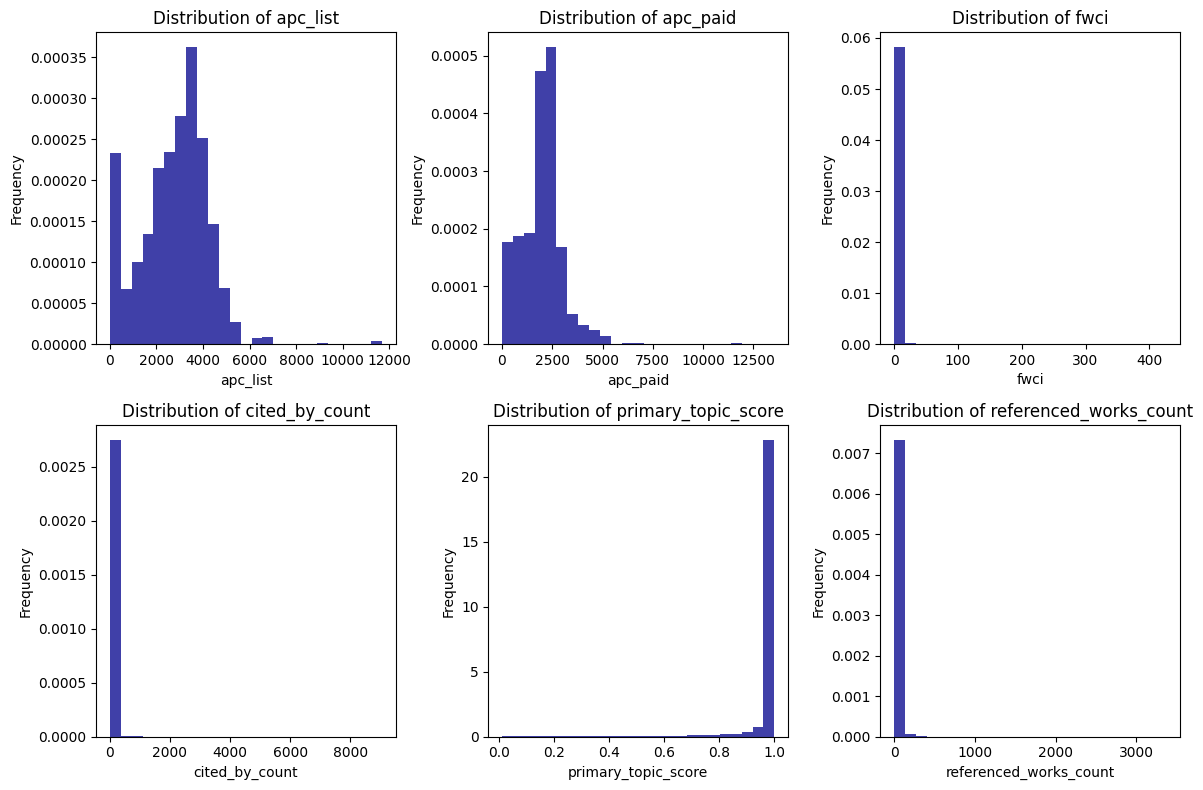

In [9]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove("publication_year")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.histplot(df[column], kde=False, stat="density", linewidth=0, color='darkblue', bins=25, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

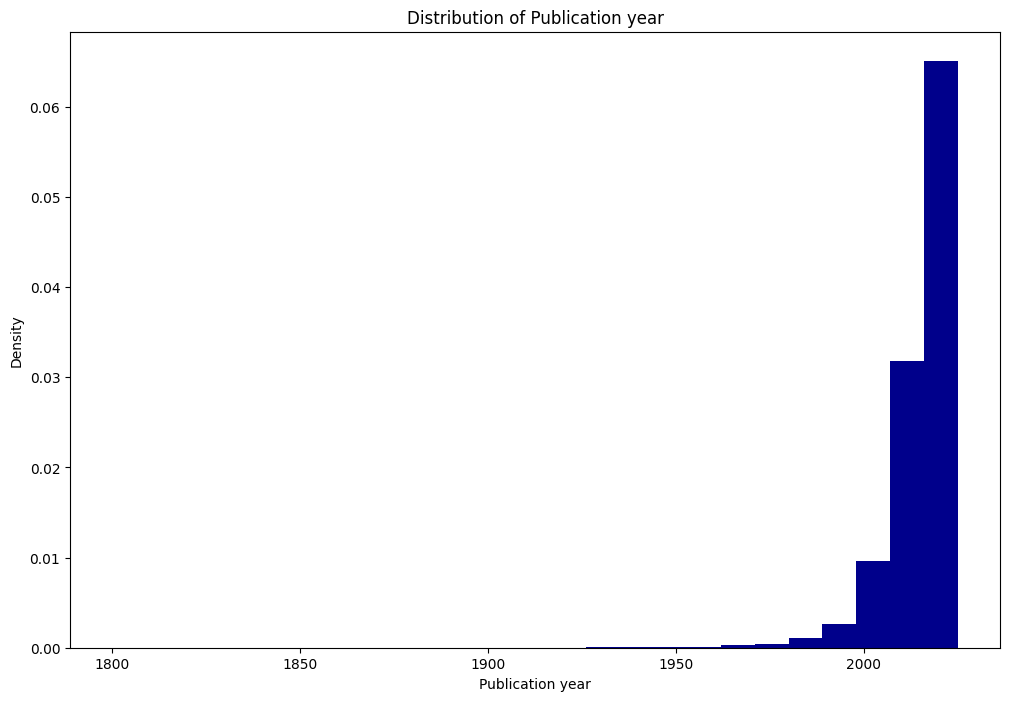

In [10]:
plt.figure(figsize=(12, 8))

sns.histplot(df['publication_year'], bins=25, kde=False,
             color='darkblue', stat='density', linewidth=0, alpha=1)

plt.title('Distribution of Publication year')
plt.xlabel('Publication year')
plt.ylabel('Density')

plt.show()

### Step 4: Plot Heatmap to Identify Correlations

In this step, we will generate a heatmap to analyze the correlation between different variables. A heatmap visualizes the correlation matrix, where each cell represents the relationship between two variables. Strong correlations (positive or negative) are highlighted with darker colors, while weak correlations are represented with lighter colors. This allows us to identify patterns and relationships in the data, which can be useful for feature selection, multicollinearity checks, and building more informed models.

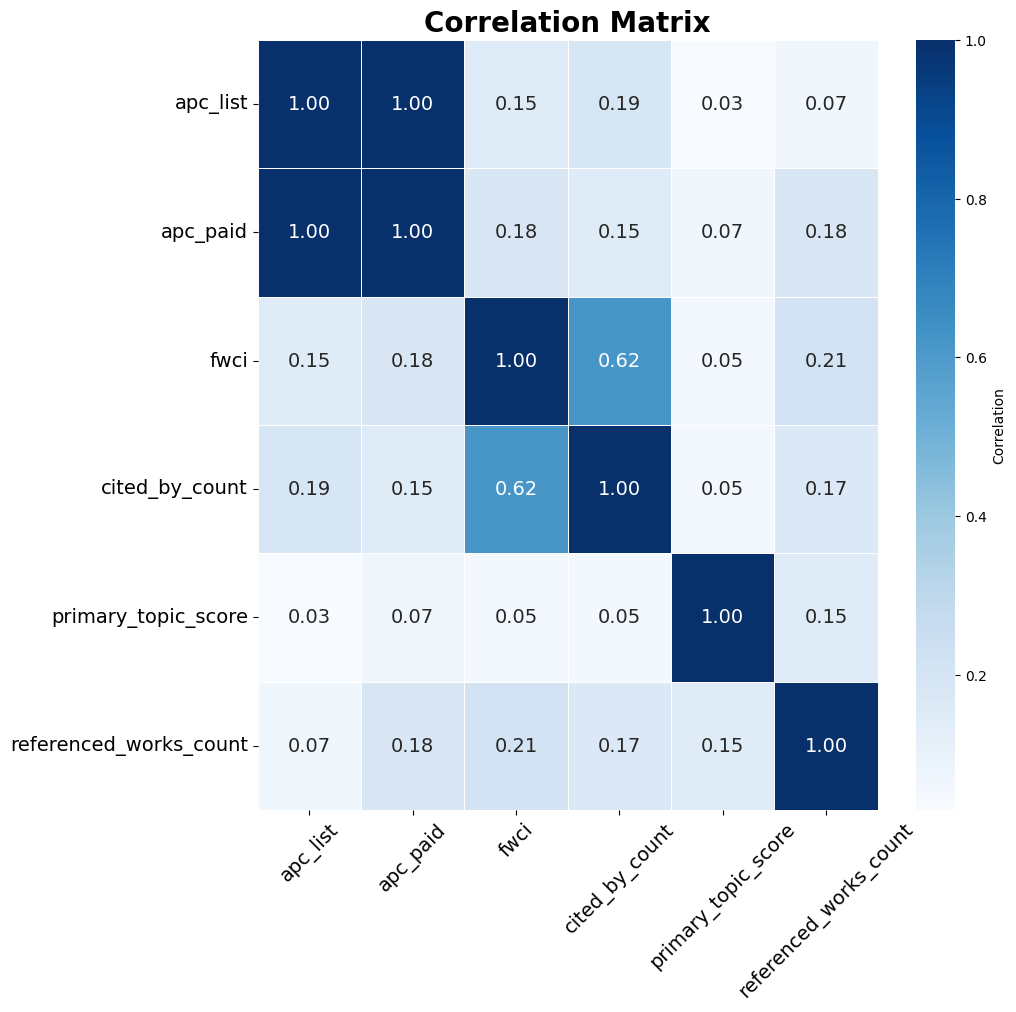

In [11]:
correlation_matrix = df[numerical_cols].corr().round(2)

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Correlation'},
            xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns,
            annot_kws={'size': 14}, linewidths=0.5)

plt.title('Correlation Matrix', fontsize=20, fontweight='bold')
plt.xticks(rotation=45, fontsize=14)
plt.yticks(rotation=0, fontsize=14)

plt.show()

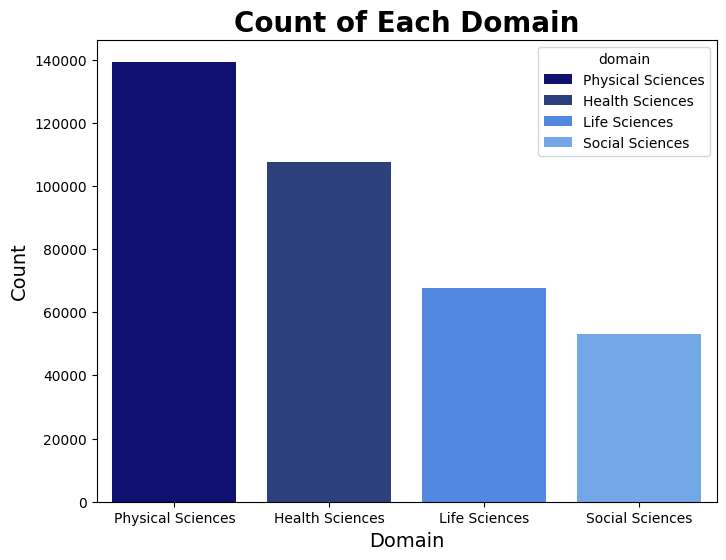

In [12]:
plt.figure(figsize=(8, 6))

sns.countplot(data=df, x='domain', hue='domain', palette=[
              "#000080", "#1E3A8A", "#3B82F6", "#60A5FA"])

plt.title('Count of Each Domain', fontsize=20, fontweight='bold')
plt.xlabel('Domain', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.show()

## Data Preprocessing

### Overview
In this section, we will perform the necessary preprocessing steps on the data to ensure it is clean and ready for analysis. This includes tasks such as handling missing values, removing duplicates, normalizing or scaling numerical features, and encoding categorical variables. Proper data preprocessing is essential for improving the quality and accuracy of our models and analyses.


### Step 1: Drop Duplicates Data

In this step, we remove any duplicate records from the dataset to ensure data integrity and avoid redundancy. Duplicates can occur when the same data is entered more than once, which may lead to skewed analysis results. By dropping duplicates, we ensure that each entry in the dataset is unique, improving the accuracy and reliability of subsequent analysis steps.

In [13]:
# apply lambda function to convert list to string
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].apply(lambda item: str(item))

display(df.sample())

,_id,doi,title,publication_year,language,is_oa,oa_status,institutions,countries,apc_list,apc_paid,fwci,cited_by_count,domain,field,primary_topic_score,referenced_works_count,sustainable_development_goals,counts_by_year
352568,675091c004aa600ab819a191,https://doi.org/10.5281/zenodo.6645136,"The Effects of the 'Our Love, Our Control' Onl...",2022,en,True,green,['Ubon Ratchathani University'],['TH'],NaN,NaN,0.0,0,Health Sciences,Health Professions,0.958,0,"[{'score': 0.77, 'display_name': 'Quality educ...",[]


In [14]:
row_before_drop_duplicates: int = len(df)
row_after_drop_duplicates: int = -1

df.drop_duplicates(inplace=True)
row_after_drop_duplicates = len(df)

In [15]:
print(f"Rows before drop duplicates: {row_before_drop_duplicates} records")
print(f"Rows after drop duplicates: {row_after_drop_duplicates} records")

Rows before drop duplicates: 372225 records
Rows after drop duplicates: 372225 records


### Step 2: Handle Missing or Null Values

In this step, we address any missing or null values in the dataset, which can negatively impact data analysis and model performance. Missing values may occur due to incomplete data collection, errors during data entry, or other reasons. It's important to handle them appropriately, either by filling in the missing values or removing rows or columns with excessive missing data.

In [16]:
df.dropna(inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58262 entries, 22 to 372221
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            58262 non-null  object 
 1   doi                            58262 non-null  object 
 2   title                          58262 non-null  object 
 3   publication_year               58262 non-null  int64  
 4   language                       58262 non-null  object 
 5   is_oa                          58262 non-null  bool   
 6   oa_status                      58262 non-null  object 
 7   institutions                   58262 non-null  object 
 8   countries                      58262 non-null  object 
 9   apc_list                       58262 non-null  float64
 10  apc_paid                       58262 non-null  float64
 11  fwci                           58262 non-null  float64
 12  cited_by_count                 58262 non-null  in

/var/folders/r3/wbw1d1y54ynghq06l4pgqg280000gn/T/ipykernel_7963/2273577569.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left', fontsize=12)


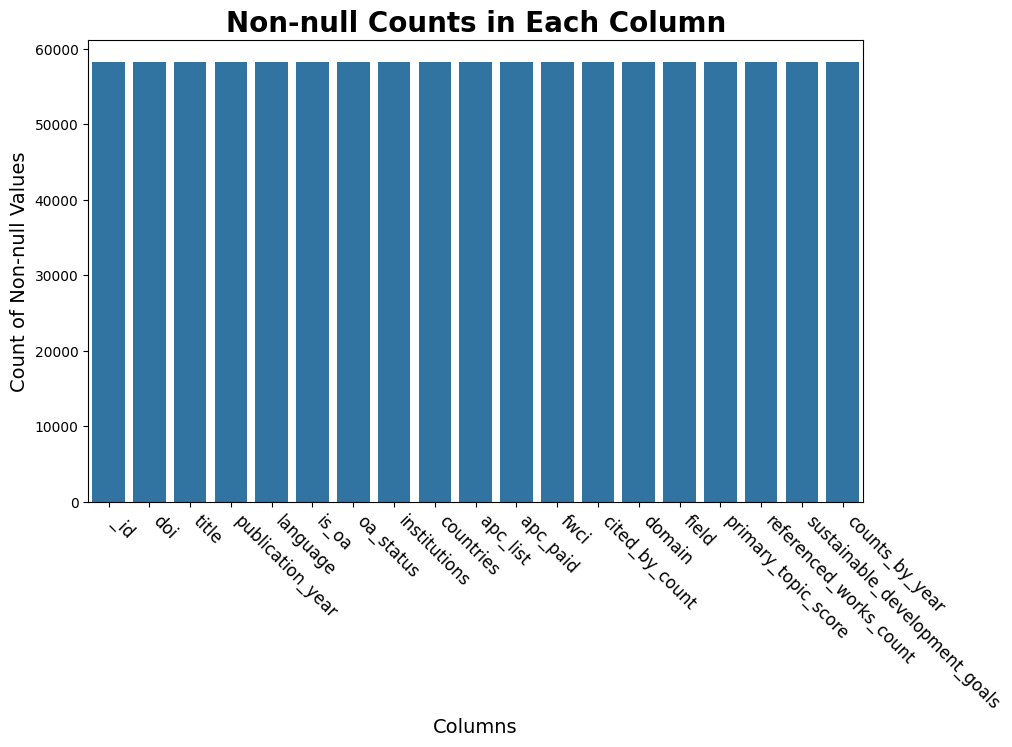

In [18]:
column_counts = df.count()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=column_counts.index, y=column_counts.values, ax=ax)

ax.set_title('Non-null Counts in Each Column', fontsize=20, fontweight='bold')
ax.set_xlabel('Columns', fontsize=14)
ax.set_ylabel('Count of Non-null Values', fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left', fontsize=12)

plt.show()

### Step 3: Select Relevant Features (Columns)

In this step, we focus on selecting the relevant columns (features) that will be used for further analysis, machine learning (ML), or artificial intelligence (AI) tasks. Not all columns in the dataset may contribute meaningfully to the predictive power or performance of a model. Selecting the right features helps improve model accuracy, reduce computational complexity, and prevent overfitting by excluding irrelevant or redundant data.

In [19]:
relevant_features = ["publication_year", "apc_paid", "cited_by_count", "referenced_works_count"]

In [20]:
df = df[relevant_features]
display(df.sample(5))

,publication_year,apc_paid,cited_by_count,referenced_works_count
135783,2021,1515.0,8,24
165531,2005,370.0,12,14
86628,2014,4640.0,18,43
126899,2019,2150.0,10,50
213555,2020,301.0,4,44


### Step 4: Handle Outliers

In this step, we identify and manage outliers—data points that deviate significantly from the rest of the dataset. Outliers can skew analysis results and lead to misleading conclusions if not properly addressed. Outliers may arise from data entry errors, unusual but valid variations, or extreme cases. It is crucial to decide whether to remove, adjust, or keep outliers depending on the nature of the data and the analysis goals.

In [21]:
# filtered only since 2018 research papers
df = df[df["publication_year"] >= 2018]
display(df.sample(5))

,publication_year,apc_paid,cited_by_count,referenced_works_count
88139,2019,200.0,16,22
149463,2024,800.0,0,64
59078,2023,860.0,6,28
56213,2019,2836.0,25,78
232591,2022,1078.0,2,34


In [22]:
for col in df.columns:
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1

    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    df[col] = df[col].apply(
        lambda x: upper_bound if x > upper_bound else (
            lower_bound if x < lower_bound else x)
    )

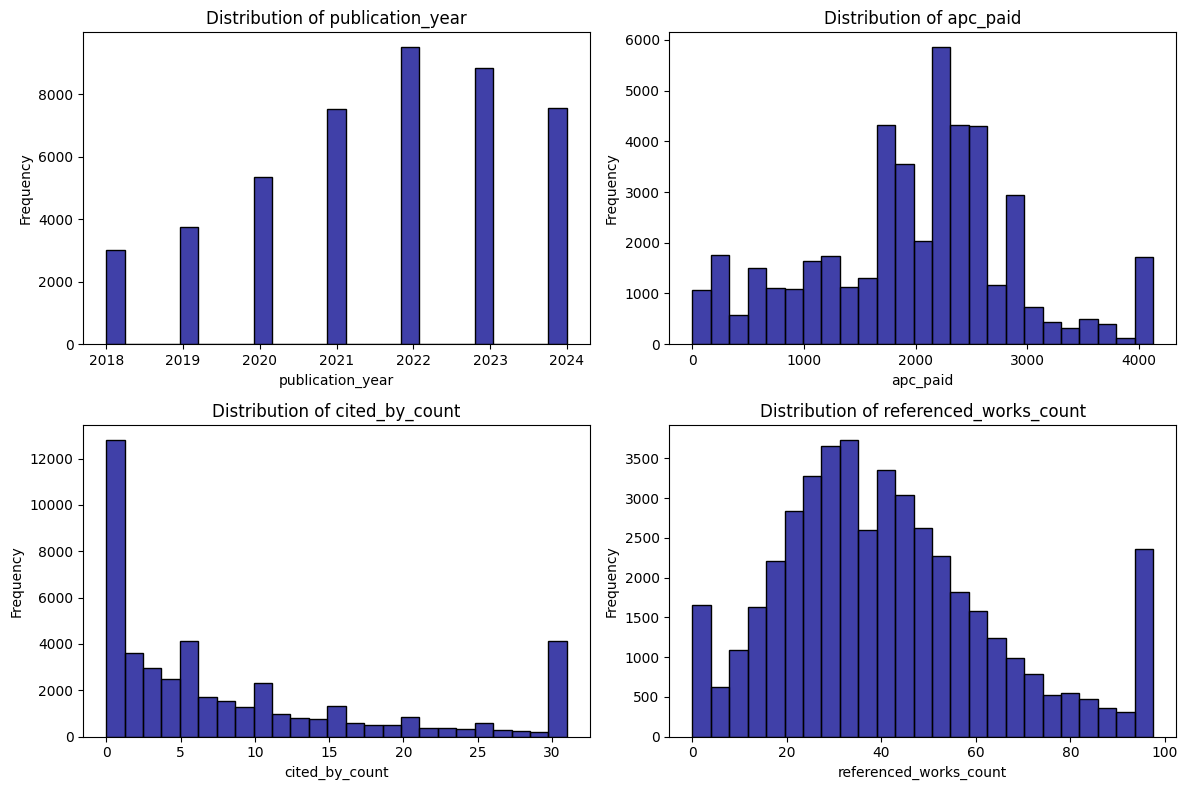

In [23]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, column in enumerate(numerical_cols):
    sns.histplot(df[column], color='darkblue', bins=25, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [24]:
# sampling cited_by_count feature for 60% of zero value
zero_df = df[df['cited_by_count'] == 0]
non_zero_df = df[df['cited_by_count'] != 0]
sampled_df = zero_df.sample(frac=0.60)

df = pd.concat([non_zero_df, sampled_df], axis=0)
df = df.reset_index(drop=True)

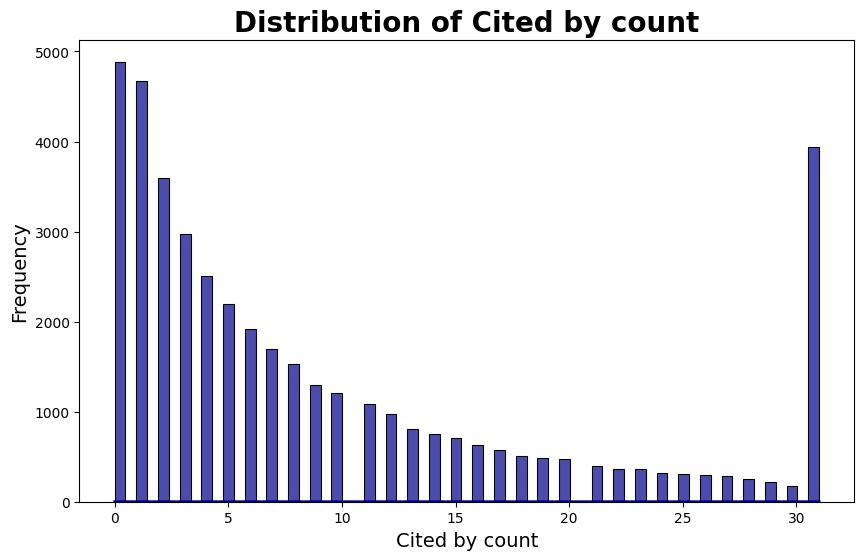

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['cited_by_count'], bins=65, kde=False,
             color='darkblue', ax=ax, alpha=0.7)

kde_values = stats.gaussian_kde(df['cited_by_count'])
kde_x = np.linspace(df['cited_by_count'].min(),
                    df['cited_by_count'].max(), 100)
kde_y = kde_values(kde_x)

ax.plot(kde_x, kde_y, color='darkblue', linewidth=2, label='KDE')

ax.set_title('Distribution of Cited by count', fontsize=20, fontweight='bold')
ax.set_xlabel('Cited by count', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

plt.show()

### Step 5: Apply Standard Scaling for Clustering and Regression Analysis

In this step, we apply standard scaling to the features in the dataset to normalize the data before performing clustering. Standard scaling transforms the data to have a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the clustering algorithm. This is particularly important for distance-based clustering methods such as K-means, where the scale of the features can heavily influence the results.


In [26]:
scaler = StandardScaler()
scaler.fit(df)

z = scaler.transform(df)
standardized_df = pd.DataFrame(z, columns=df.columns)

display(standardized_df.sample(5))

,publication_year,apc_paid,cited_by_count,referenced_works_count
10252,-0.284144,-0.878448,0.977428,-0.166298
30546,0.861958,-0.270185,-0.861942,-1.201118
18456,0.288907,-0.104295,-0.146631,-1.028648
463,0.861958,2.356405,2.203675,2.399193
25232,-0.284144,0.548206,-0.248819,-0.511238


## ML Model Training

### Overview
In this session, we will explore two important machine learning techniques: K-Means Clustering. The focus will be on understanding how this algorithms work, its use cases, and how to implement its effectively. We will start by applying K-Means clustering to group data points into meaningful clusters.


### K-Means Clustering

In [27]:
target_columns = df.columns.tolist()

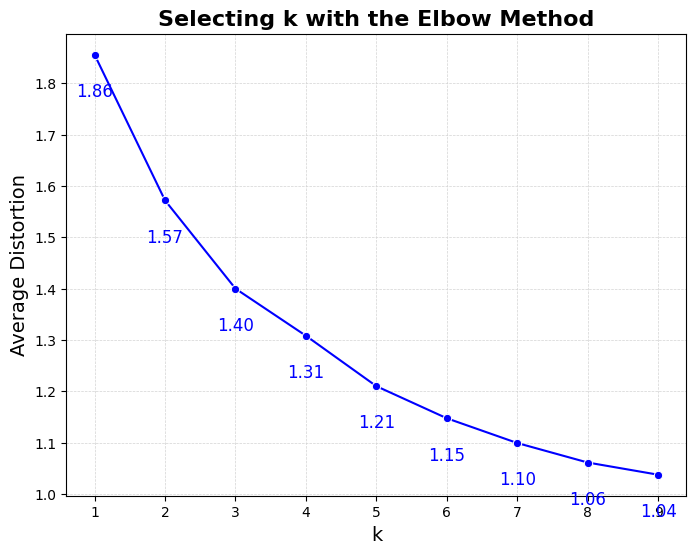

In [35]:
K = range(1, 10)
meandistortions = []

for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, random_state=0)
    kmeans.fit(standardized_df)
    meandistortions.append(
        sum(np.min(cdist(standardized_df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / standardized_df.shape[0])

fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(x=list(K), y=meandistortions, marker='o', color='blue', ax=ax)

for i in range(len(K)):
    ax.annotate(f'{meandistortions[i]:.2f}',
                (K[i], meandistortions[i]),
                textcoords="offset points",
                xytext=(0, -30),
                ha='center', fontsize=12, color='blue')

ax.set_title('Selecting k with the Elbow Method',
             fontsize=16, fontweight='bold')
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('Average Distortion', fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

plt.show()

In [29]:
model = KMeans(n_clusters=3, max_iter=5000, n_init='auto', random_state=0)
model.fit(standardized_df)

KMeans(max_iter=5000, n_clusters=3, random_state=0)

In [30]:
model.cluster_centers_

array([[-0.35947691, -0.92867439, -0.40975067, -0.73595975],
       [ 0.69264978,  0.38789277, -0.52739719,  0.21440539],
       [-0.83488168,  0.39317838,  1.44447018,  0.48078815]])

In [31]:
model.transform(standardized_df)

array([[4.56887765, 4.31801843, 2.45379414],
       [4.41816629, 4.51030451, 2.54445751],
       [3.05177419, 3.58846555, 1.55455296],
       ...,
       [2.52778142, 1.78490812, 3.61786231],
       [3.51419044, 1.75294818, 3.54493367],
       [3.07114237, 1.3213129 , 3.10991538]])

In [32]:
model.labels_

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [33]:
df['cluster'] = model.labels_
df['cluster'].value_counts()

cluster
1    19225
0    12536
2    10593
Name: count, dtype: int64

2024-12-10 03:17:50,042 	 INFO 	 matplotlib.category 	 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/r3/wbw1d1y54ynghq06l4pgqg280000gn/T/ipykernel_7963/4008965977.py:16: UserWarning:

The palette list has more values (8) than needed (3), which may not be intended.

2024-12-10 03:17:50,057 	 INFO 	 matplotlib.category 	 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-10 03:17:50,097 	 INFO 	 matplotlib.category 	 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/r3/wbw1d1y54ynghq06l4pgqg280000gn/T/ipykernel_7963/4008965977.py:16: UserW

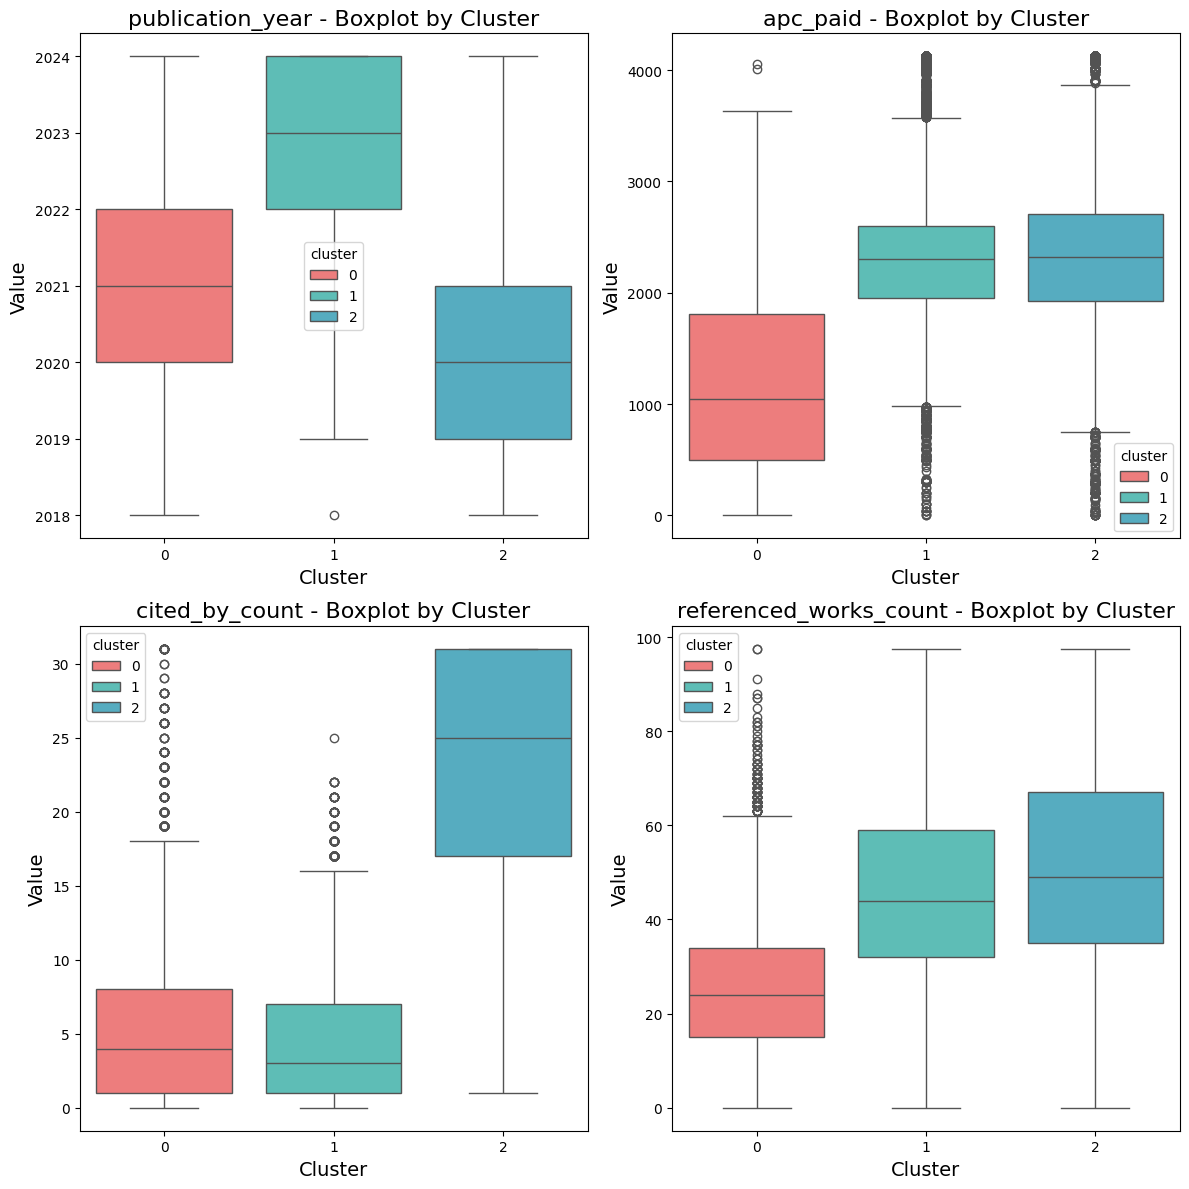

In [40]:
ncols = 2
num_cols = len(target_columns)
nrows = int(np.ceil(num_cols / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FDCB6E',
          '#6C5CE7', '#A8E6CF', '#FF8ED4', '#FAD390']

for i, col in enumerate(target_columns):
    row = i // ncols
    col_pos = i % ncols

    ax = axes[row, col_pos] if nrows > 1 else axes[col_pos]

    sns.boxplot(x='cluster', y=col, data=df, ax=ax, palette=colors, hue='cluster')

    ax.set_title(f'{col} - Boxplot by Cluster', fontsize=16)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)

    for cluster in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster][col]
        outliers = cluster_data[cluster_data.isin(
            cluster_data[((cluster_data - cluster_data.mean()) /
                          cluster_data.std()).abs() > 3]
        )]

plt.tight_layout()
plt.show()

In [34]:
interactive_boxplot = create_interactive_boxplot(df, target_columns)
interactive_boxplot.show()